## Dependency analysis

This notebook contains analysis of dependencies in Common Criteria certificates.

In [1]:
# QUICK FIX: local import of sec-certs => gonna be deleted later
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections 
import datetime

from sec_certs.dataset.common_criteria import CCDataset
from typing import Tuple, List

plt.style.use("ggplot")

In [3]:
dset: CCDataset = CCDataset.from_json("/home/george/Downloads/dependency_json_final.json")
dset._compute_dependencies()
df = dset.to_pandas()

print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset has 4616 rows and 20 columns.


In [4]:
df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,st_link,manufacturer_web,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting
dgst,,,,,,,,,,,,,,,,,,,,
a89ee15539d006d1,NaN,DriveLock Agent 2019.2 (Device and Application...,active,Access Control Devices and Systems,DriveLock SE,SE,"[ALC_FLR.3, EAL3]",2021-04-07,2026-04-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.drivelock.com/,[2019.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
309ac2fd7f2dcf17,NaN,NetIQ Identity Manager 4.7,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.2, EAL3+]",2020-06-15,2025-06-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.7],NaN,NaN,NaN,NaN,NaN,NaN,NaN
8cf86948f02f047d,KECS-CR-19-70,Magic SSO V4.0,active,Access Control Devices and Systems,"Dreamsecurity Co., Ltd.",KR,[],2019-11-15,2024-11-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.dreamsecurity.com/,[4.0],NaN,NaN,NaN,NaN,NaN,NaN,NaN
0fc32111e368dcf5,NSCIB-CC-0006151-CR,NetIQ Access Manager 4.5,active,Access Control Devices and Systems,"NetIQ, Incorporated",NL,"[ALC_FLR.1, EAL3+]",2019-11-07,2024-11-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.5],[cpe:2.3:a:netiq:access_manager:4.5:-:*:*:*:*:...,NaN,NaN,NaN,NaN,NaN,NaN
5e87de1cddf1ae43,NaN,Illumio Adaptive Security Platform v18.2.2,active,Access Control Devices and Systems,Illumio,CA,[],2019-07-12,2024-07-12,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.illumio.com/,[18.2.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4616 entries, a89ee15539d006d1 to 09b17cb9b3c8b1bb
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cert_id                 3252 non-null   object        
 1   name                    4616 non-null   object        
 2   status                  4616 non-null   category      
 3   category                4616 non-null   category      
 4   manufacturer            4615 non-null   object        
 5   scheme                  4616 non-null   category      
 6   security_level          4616 non-null   object        
 7   not_valid_before        4616 non-null   datetime64[ns]
 8   not_valid_after         4327 non-null   datetime64[ns]
 9   report_link             4616 non-null   object        
 10  st_link                 4616 non-null   object        
 11  manufacturer_web        4554 non-null   object        
 12  extracted_versions      46

In [6]:
df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,st_link,manufacturer_web,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting
dgst,,,,,,,,,,,,,,,,,,,,
a89ee15539d006d1,NaN,DriveLock Agent 2019.2 (Device and Application...,active,Access Control Devices and Systems,DriveLock SE,SE,"[ALC_FLR.3, EAL3]",2021-04-07,2026-04-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.drivelock.com/,[2019.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
309ac2fd7f2dcf17,NaN,NetIQ Identity Manager 4.7,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.2, EAL3+]",2020-06-15,2025-06-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.7],NaN,NaN,NaN,NaN,NaN,NaN,NaN
8cf86948f02f047d,KECS-CR-19-70,Magic SSO V4.0,active,Access Control Devices and Systems,"Dreamsecurity Co., Ltd.",KR,[],2019-11-15,2024-11-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.dreamsecurity.com/,[4.0],NaN,NaN,NaN,NaN,NaN,NaN,NaN
0fc32111e368dcf5,NSCIB-CC-0006151-CR,NetIQ Access Manager 4.5,active,Access Control Devices and Systems,"NetIQ, Incorporated",NL,"[ALC_FLR.1, EAL3+]",2019-11-07,2024-11-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.5],[cpe:2.3:a:netiq:access_manager:4.5:-:*:*:*:*:...,NaN,NaN,NaN,NaN,NaN,NaN
5e87de1cddf1ae43,NaN,Illumio Adaptive Security Platform v18.2.2,active,Access Control Devices and Systems,Illumio,CA,[],2019-07-12,2024-07-12,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.illumio.com/,[18.2.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filter top 10 manufacturers and see which categories are the most common

In [7]:
MANUFACTURER_COUNT = 10
top_manufacturers_list = df[df["manufacturer"].notna()]["manufacturer"].value_counts().head(MANUFACTURER_COUNT).index.tolist()
top_manufacturers_df = df[df["manufacturer"].isin(top_manufacturers_list)]
top_manufacturers_df["category"].value_counts()

ICs, Smart Cards and Smart Card-Related Devices and Systems    445
Multi-Function Devices                                         164
Other Devices and Systems                                      108
Network and Network-Related Devices and Systems                 96
Operating Systems                                               75
Trusted Computing                                               44
Databases                                                       30
Data Protection                                                 25
Mobility                                                        23
Boundary Protection Devices and Systems                         19
Access Control Devices and Systems                              13
Detection Devices and Systems                                    5
Key Management Systems                                           4
Products for Digital Signatures                                  3
Biometric Systems and Devices                                 

### How many archived certificates are in dataset?

In [8]:
archived_df = df[df["status"] == "archived"]
print(f"There are total {archived_df.shape[0]} archived certificates.")

There are total 3057 archived certificates.


### How many active certificates are in dataset?

In [9]:
active_df = df[df["status"] == "active"]
print(f"There are total {active_df.shape[0]} active certificates.")

There are total 1559 active certificates.


Text(0.5, 1.0, 'Archived certs vs. active certs')

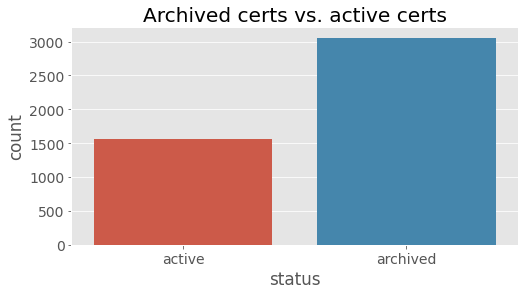

In [10]:
plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size': 14})
sns.countplot(x=df["status"]).set_title("Archived certs vs. active certs")

### Which certificates are referenced at least by one certificate? 

In [11]:
def is_directly_affected_by(references):
    if references is np.nan:
        return False
    
    return True

def count_directly_affected_by(references):
    if references is np.nan:
        return np.nan
    return len(references)

directly_affected_by_df = df.copy()
directly_affected_by_df["is_directly_affected_by"] = df["directly_affected_by"].apply(is_directly_affected_by)
directly_affected_by_df["directly_affected_by_sum"] = directly_affected_by_df["directly_affected_by"].apply(count_directly_affected_by)
directly_affected_by_df.sort_values(by="directly_affected_by_sum", ascending=False, inplace=True)
directly_affected_by_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_directly_affected_by,directly_affected_by_sum
dgst,,,,,,,,,,,,,,,,,,,,,
f041e5b526e79ef4,BSI-DSZ-CC-0410-2007,"NXP Secure Smart Card Controller P5CD080V0B, P...",archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH Business Line ...,DE,"[ALC_DVS.2, AVA_MSU.3, AVA_VLA.4, EAL5+]",2007-07-05,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,[-],NaN,NaN,NaN,"[BSI-DSZ-CC-0798-2012, BSI-DSZ-CC-0797-2012, B...","{BSI-DSZ-CC-0704-2010, BSI-DSZ-CC-0447-2008, B...",{BSI-DSZ-CC-0404-2007},{BSI-DSZ-CC-0404-2007},True,33.0
9dab3f1341f54c42,BSI-DSZ-CC-0555-2009,NXP Smart Card Controller P5CD081V1A and its m...,archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors,DE,[EAL5+],2009-11-10,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,[-],NaN,NaN,NaN,"[BSI-DSZ-CC-0784-2013, BSI-DSZ-CC-0857-2013, B...","{BSI-DSZ-CC-0702-2011, BSI-DSZ-CC-0860-2013, A...",NaN,NaN,True,19.0
dbbf02a1cd0ad33b,ANSSI-CC-2010/02,STMicroelectronics SA23YR48/80B and SB23YR48/8...,archived,"ICs, Smart Cards and Smart Card-Related Device...",STMicroelectronics,FR,"[ALC_FLR.1, EAL6+]",2010-02-10,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,"[2.0, 3.0]",NaN,NaN,NaN,"[BSI-DSZ-CC-0877-2013, ANSSI-CC-2010/34, BSI-D...","{ANSSI-CC-2010/31, ANSSI-CC-2010/34, ANSSI-CC-...",NaN,NaN,True,19.0
7d4585a4b5b6e873,ANSSI-CC-2010/02,Ucard UBJ31-G11 V1.1,archived,"ICs, Smart Cards and Smart Card-Related Device...",UBIVELOX,KR,"[ALC_DVS.2, AVA_VAN.5, EAL4+]",2012-10-31,2019-06-01,https://www.commoncriteriaportal.org/files/epf...,...,[1.1],NaN,NaN,NaN,"[BSI-DSZ-CC-0877-2013, ANSSI-CC-2010/34, BSI-D...","{ANSSI-CC-2010/31, ANSSI-CC-2010/34, ANSSI-CC-...",NaN,NaN,True,19.0
f2c2231b0ffae4d7,BSI-DSZ-CC-0978-2016,NXP Secure Smart Card Controller P60x144/080yV...,archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH Business Line ...,DE,"[ALC_FLR.1, ASE_TSS.2, EAL6+]",2016-02-05,2021-02-05,https://www.commoncriteriaportal.org/files/epf...,...,[-],NaN,NaN,NaN,"[BSI-DSZ-CC-0978-V2-2017, BSI-DSZ-CC-0957-V2-2...","{ANSSI-CC-2016/40, ANSSI-CC-2016/29, BSI-DSZ-C...",NaN,NaN,True,18.0


Text(0.5, 1.0, 'Which certificates are referenced at least by one certificate vs. which are affected by no certificates')

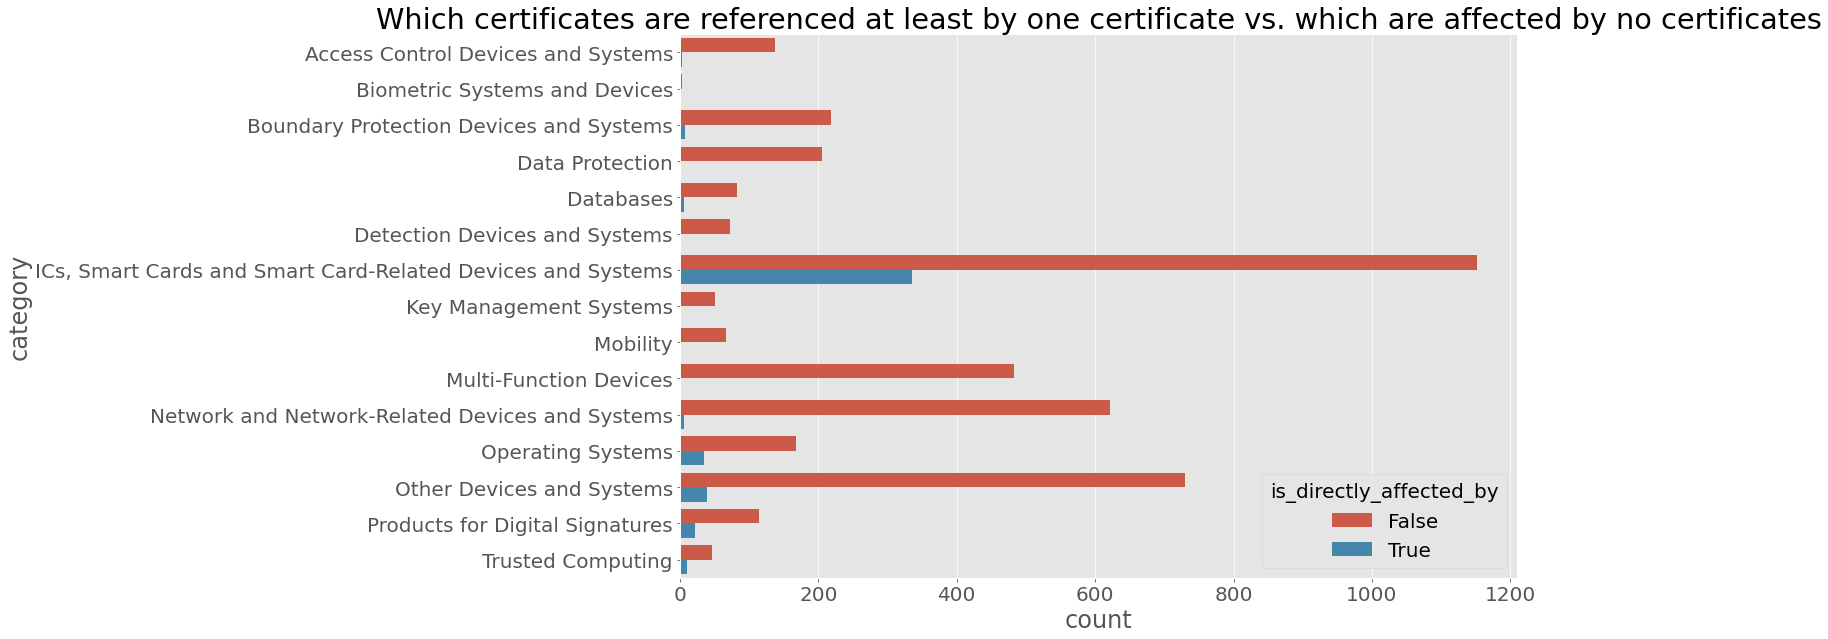

In [13]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20})
sns.countplot(y="category", hue="is_directly_affected_by", data=directly_affected_by_df).set_title("Which certificates are referenced at least by one certificate vs. which are affected by no certificates")

### Which certificates are referencing no other?

In [15]:
no_affecting_df = df[df["directly_affecting"].isna() & df["indirectly_affecting"].isna()]

print(f"There are total {no_affecting_df.shape[0]} certificates referencing no other certificates.")

There are total 3970 certificates referencing no other certificates.


In [16]:
no_affecting_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,st_link,manufacturer_web,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting
dgst,,,,,,,,,,,,,,,,,,,,
a89ee15539d006d1,NaN,DriveLock Agent 2019.2 (Device and Application...,active,Access Control Devices and Systems,DriveLock SE,SE,"[ALC_FLR.3, EAL3]",2021-04-07,2026-04-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.drivelock.com/,[2019.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
309ac2fd7f2dcf17,NaN,NetIQ Identity Manager 4.7,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.2, EAL3+]",2020-06-15,2025-06-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.7],NaN,NaN,NaN,NaN,NaN,NaN,NaN
8cf86948f02f047d,KECS-CR-19-70,Magic SSO V4.0,active,Access Control Devices and Systems,"Dreamsecurity Co., Ltd.",KR,[],2019-11-15,2024-11-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.dreamsecurity.com/,[4.0],NaN,NaN,NaN,NaN,NaN,NaN,NaN
0fc32111e368dcf5,NSCIB-CC-0006151-CR,NetIQ Access Manager 4.5,active,Access Control Devices and Systems,"NetIQ, Incorporated",NL,"[ALC_FLR.1, EAL3+]",2019-11-07,2024-11-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.5],[cpe:2.3:a:netiq:access_manager:4.5:-:*:*:*:*:...,NaN,NaN,NaN,NaN,NaN,NaN
5e87de1cddf1ae43,NaN,Illumio Adaptive Security Platform v18.2.2,active,Access Control Devices and Systems,Illumio,CA,[],2019-07-12,2024-07-12,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.illumio.com/,[18.2.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN


### How many no affecting certificates are affected by other certificates?

In [17]:
affected_but_no_affecting_df = no_affecting_df[no_affecting_df["directly_affected_by"].notna() & no_affecting_df["indirectly_affected_by"].notna()]
print(f"There are total of {affected_but_no_affecting_df.shape[0]} certificates which are affected by other certificates and affecting no certificates.")

There are total of 158 certificates which are affected by other certificates and affecting no certificates.


### How many certificates are not affected by other certificates, nor affecting other certificates?

In [18]:
def is_no_affecting_nor_affected(directly_affecting, indirectly_affecting, directly_affected_by, indirectly_affected_by):
    if directly_affecting is np.nan and indirectly_affecting is np.nan and directly_affected_by is np.nan and indirectly_affected_by is np.nan:
        return True
    
    return False


no_affecting_no_affected_df = df.copy()
no_affecting_no_affected_df["is_no_affecting_nor_affected"] = df.apply(lambda x: is_no_affecting_nor_affected(x["directly_affecting"], x["indirectly_affecting"], x["directly_affected_by"], x["indirectly_affected_by"]), axis=1)
no_affecting_no_affected_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,manufacturer_web,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_no_affecting_nor_affected
dgst,,,,,,,,,,,,,,,,,,,,,
a89ee15539d006d1,NaN,DriveLock Agent 2019.2 (Device and Application...,active,Access Control Devices and Systems,DriveLock SE,SE,"[ALC_FLR.3, EAL3]",2021-04-07,2026-04-07,https://www.commoncriteriaportal.org/files/epf...,...,https://www.drivelock.com/,[2019.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
309ac2fd7f2dcf17,NaN,NetIQ Identity Manager 4.7,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.2, EAL3+]",2020-06-15,2025-06-15,https://www.commoncriteriaportal.org/files/epf...,...,https://www.netiq.com/,[4.7],NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
8cf86948f02f047d,KECS-CR-19-70,Magic SSO V4.0,active,Access Control Devices and Systems,"Dreamsecurity Co., Ltd.",KR,[],2019-11-15,2024-11-15,https://www.commoncriteriaportal.org/files/epf...,...,https://www.dreamsecurity.com/,[4.0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
0fc32111e368dcf5,NSCIB-CC-0006151-CR,NetIQ Access Manager 4.5,active,Access Control Devices and Systems,"NetIQ, Incorporated",NL,"[ALC_FLR.1, EAL3+]",2019-11-07,2024-11-07,https://www.commoncriteriaportal.org/files/epf...,...,https://www.netiq.com/,[4.5],[cpe:2.3:a:netiq:access_manager:4.5:-:*:*:*:*:...,NaN,NaN,NaN,NaN,NaN,NaN,True
5e87de1cddf1ae43,NaN,Illumio Adaptive Security Platform v18.2.2,active,Access Control Devices and Systems,Illumio,CA,[],2019-07-12,2024-07-12,https://www.commoncriteriaportal.org/files/epf...,...,https://www.illumio.com/,[18.2.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


Text(0.5, 1.0, 'Distribution of schemes which certs from categories are not affecting, nor affected by other certs')

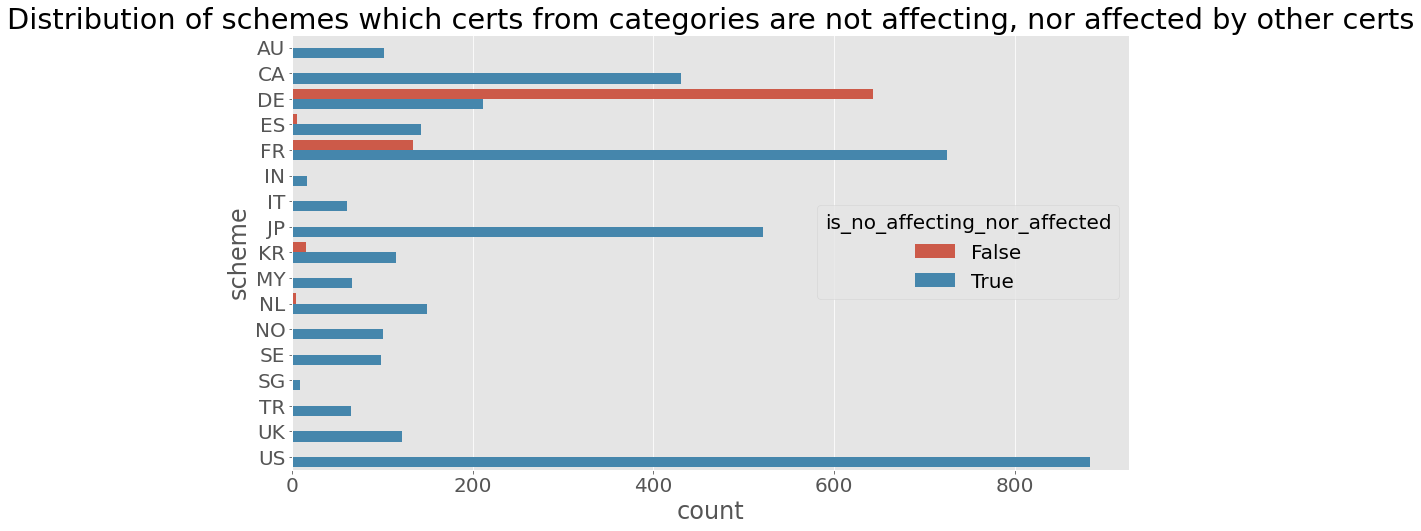

In [19]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 20})
sns.countplot(y="scheme", hue="is_no_affecting_nor_affected", data=no_affecting_no_affected_df).set_title("Distribution of schemes which certs from categories are not affecting, nor affected by other certs")

### Which certificates are dependent on the archived certificates?

In [20]:
archived_cert_id_list = df[df["cert_id"].notna() & (df["status"] == "archived")]["cert_id"].tolist()

def contains_archived_cert_dependency(affected_by):
    if affected_by is np.nan:
        return False
    
    for cert_id in affected_by:
        if cert_id in archived_cert_id_list:
            return True
        
    return False


depends_on_archived_df = df.copy()
depends_on_archived_df["depends_on_archived"] = depends_on_archived_df["directly_affected_by"].apply(contains_archived_cert_dependency)
total_records_dependent = sum(depends_on_archived_df["depends_on_archived"])
print(f"Total {total_records_dependent} certificates are affected by at least one archived certicates.")

Total 311 certificates are affected by at least one archived certicates.


Text(0.5, 1.0, 'Distribution of categories among certificates dependent on archived certs.')

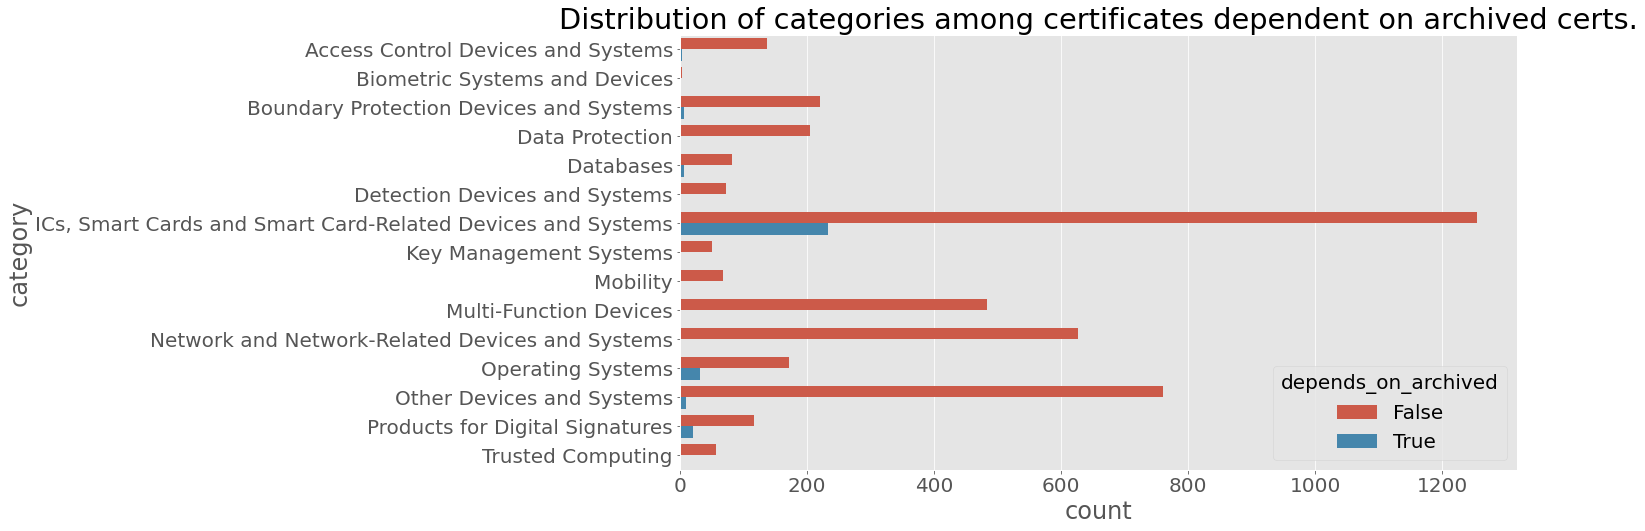

In [21]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 20})
sns.countplot(y="category", hue="depends_on_archived", data=depends_on_archived_df).set_title("Distribution of categories among certificates dependent on archived certs.")

Text(0.5, 1.0, 'Distribution of schemes among certificates dependent on archived certs.')

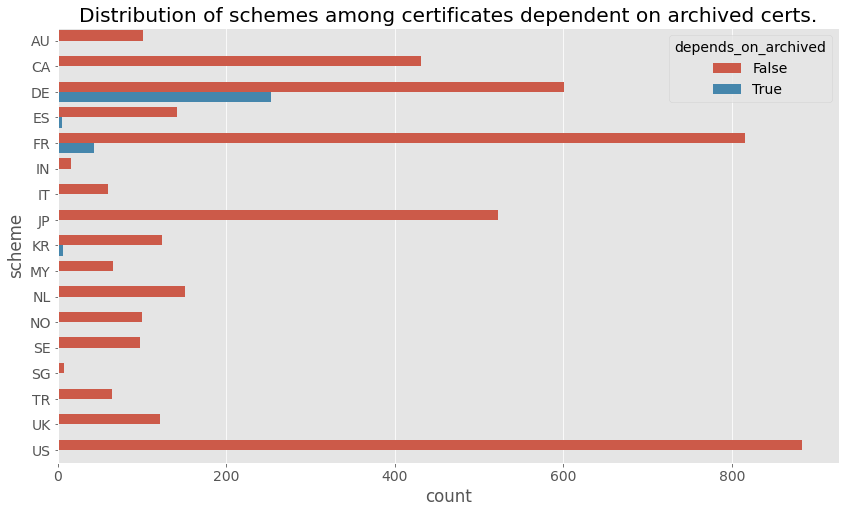

In [22]:
plt.figure(figsize=(14,8))
plt.rcParams.update({'font.size': 14})
sns.countplot(y="scheme", hue="depends_on_archived", data=depends_on_archived_df).set_title("Distribution of schemes among certificates dependent on archived certs.")

### How frequently are BSI certificates referencing ANSSI certs and vice versa?

In [23]:
from typing import Set


def is_bsi_cert(cert_id: str) -> bool:
    if cert_id is np.nan:
        return False
    
    if cert_id.lower().startswith("bsi"):
        return True
    
    return False


def is_anssi_cert(cert_id: str) -> bool:
    if cert_id is np.nan:
        return False
    
    if cert_id.lower().startswith("anssi"):
        return True

    return False


def is_affecting_anssi(directly_affecting: Set[str]) -> bool:
    if directly_affecting is np.nan:
        return False
    
    for cert_id in directly_affecting:
        if is_anssi_cert(cert_id):
            return True
        
    return False


def is_affecting_bsi(directly_affecting: Set[str]) -> bool:
    if directly_affecting is np.nan:
        return False
    
    for cert_id in directly_affecting:
        if is_bsi_cert(cert_id):
            return True
    
    return False
    
    
df["is_bsi_cert"] = df["cert_id"].apply(is_bsi_cert)
df["is_anssi_cert"] = df["cert_id"].apply(is_anssi_cert)

bsi_df = df[df["is_bsi_cert"] == True].copy()
anssi_df = df[df["is_anssi_cert"] == True].copy()

bsi_df["is_affecting_anssi"] = bsi_df["directly_affecting"].apply(is_affecting_anssi)
bsi_affecting_anssi_df = bsi_df[bsi_df["is_affecting_anssi"] == True]

anssi_df["is_affecting_bsi"] = anssi_df["directly_affecting"].apply(is_affecting_bsi)
anssi_affecting_bsi_df = anssi_df[anssi_df["is_affecting_bsi"] == True]

bsi_total_records = bsi_df.shape[0]
anssi_total_records = anssi_df.shape[0]
bsi_affecting_records = bsi_affecting_anssi_df.shape[0]
anssi_affecting_records = anssi_affecting_bsi_df.shape[0]

print(f"There are {bsi_affecting_records} BSI certs affecting ANSSI certs out of total {bsi_total_records} BSI certs.")
print(f"There are {anssi_affecting_records} ANSSI certs affecting BSI certs out of total {anssi_total_records} ANSSI certs.")

print(f"Success hit for BSI certs: {bsi_affecting_records / bsi_total_records}")
print(f"Success hit for ANSSI certs: {anssi_affecting_records / anssi_total_records}")

There are 16 BSI certs affecting ANSSI certs out of total 831 BSI certs.
There are 38 ANSSI certs affecting BSI certs out of total 682 ANSSI certs.
Success hit for BSI certs: 0.019253910950661854
Success hit for ANSSI certs: 0.05571847507331378


In [24]:
bsi_affecting_anssi_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,is_affecting_anssi
dgst,,,,,,,,,,,,,,,,,,,,,
424f6d496746258b,BSI-DSZ-CC-1064-2020,MTCOS Pro 2.5 EAC with PACE / ST31G480 D01,active,"ICs, Smart Cards and Smart Card-Related Device...",MaskTech International GmbH,DE,"[ALC_DVS.2, AVA_VAN.5, EAL5+]",2020-09-29,2025-09-29,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,[BSI-DSZ-CC-1065-2020],{BSI-DSZ-CC-1065-2020},"{ANSSI-CC-2019/12, BSI-DSZ-CC-0995-2018}","{BSI-DSZ-CC-0973-V2-2016, ANSSI-CC-2019/12, BS...",True,False,True
b8437dbfeeaf0f04,BSI-DSZ-CC-1065-2020,MTCOS Pro 2.5 EAC with PACE / ST31G480 D01 (BAC),active,"ICs, Smart Cards and Smart Card-Related Device...",MaskTech International GmbH,DE,"[ALC_DVS.2, EAL4+]",2020-09-29,2025-09-29,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,"{ANSSI-CC-2019/12, BSI-DSZ-CC-1064-2020}","{BSI-DSZ-CC-0973-V2-2016, ANSSI-CC-2019/12, BS...",True,False,True
4832a44c0df0bad2,BSI-DSZ-CC-1074-V2-2020,Xaica-Alpha PLUS ePassport on MTCOS Pro 2.5 wi...,active,"ICs, Smart Cards and Smart Card-Related Device...",MaskTech International GmbH,DE,"[ALC_DVS.2, EAL4+]",2020-07-30,2025-07-30,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-1073-V2, ANSSI-CC-2019/12, BSI-DSZ...","{BSI-DSZ-CC-1073-V2, BSI-DSZ-CC-1074-V2, BSI-D...",True,False,True
7f9eb1b8217d15ad,BSI-DSZ-CC-1073-V2-2020,Xaica-Alpha PLUS ePassport on MTCOS Pro 2.5 wi...,active,"ICs, Smart Cards and Smart Card-Related Device...",MaskTech International GmbH,DE,"[ALC_DVS.2, AVA_VAN.5, EAL4+]",2020-07-30,2025-07-30,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-1073-V2, ANSSI-CC-2019/12, BSI-DSZ...","{BSI-DSZ-CC-1073-V2, BSI-DSZ-CC-1074-V2, BSI-D...",True,False,True
06e505abb8dad1b8,BSI-DSZ-CC-1003-2018,Smart Meter Gateway Security Module Applicatio...,active,"ICs, Smart Cards and Smart Card-Related Device...",Gemalto,DE,"[AVA_VAN.5, EAL4]",2018-09-18,2028-09-18,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-0891-V2-2016, ANSSI-CC-2017/54}","{BSI-DSZ-CC-0782-2012, BSI-DSZ-CC-0891-V2-2016...",True,False,True


### Which certificates are referencing each other? (= are crossed referenced)

In [31]:
def is_already_involved(cross_reference_list: List[Tuple[str, str]], certs_set: Set[str]) -> bool:
    return certs_set in cross_reference_list

def is_cert_affecting_other_cert(root_cert_id: str, affected_cert_id: str) -> bool:
    return affected_cert_id in cross_df[cross_df["cert_id"] == root_cert_id].iloc[0]["directly_affecting"]

cross_reference_list: List[Set[str]] = []
cross_df = df[(df["cert_id"].notna()) & (df["directly_affecting"].notna())]
count = 1
total = cross_df.shape[0]

for cert_record in cross_df.itertuples():
    cert_id = cert_record.cert_id

    for another_cert_record in cross_df.itertuples():

        another_cert_id = another_cert_record.cert_id
        
        if cert_record.cert_id == another_cert_record.cert_id:
            continue
            
        certs_set = set([cert_id, another_cert_id])
        
        if is_cert_affecting_other_cert(cert_id, another_cert_id) and is_cert_affecting_other_cert(another_cert_id, cert_id) and not is_already_involved(cross_reference_list, certs_set):
            cross_reference_list.append(certs_set)
    count += 1 
    
    
print(f"Total of {len(cross_reference_list)} crossed referenced certificates.")
print(cross_reference_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


### What are the EAL levels typically affecting a certificate? E.g. are certificates referencing EAL5 typically higher or same level?

In [32]:
df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert
dgst,,,,,,,,,,,,,,,,,,,,,
a89ee15539d006d1,NaN,DriveLock Agent 2019.2 (Device and Application...,active,Access Control Devices and Systems,DriveLock SE,SE,"[ALC_FLR.3, EAL3]",2021-04-07,2026-04-07,https://www.commoncriteriaportal.org/files/epf...,...,[2019.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
309ac2fd7f2dcf17,NaN,NetIQ Identity Manager 4.7,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.2, EAL3+]",2020-06-15,2025-06-15,https://www.commoncriteriaportal.org/files/epf...,...,[4.7],NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
8cf86948f02f047d,KECS-CR-19-70,Magic SSO V4.0,active,Access Control Devices and Systems,"Dreamsecurity Co., Ltd.",KR,[],2019-11-15,2024-11-15,https://www.commoncriteriaportal.org/files/epf...,...,[4.0],NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
0fc32111e368dcf5,NSCIB-CC-0006151-CR,NetIQ Access Manager 4.5,active,Access Control Devices and Systems,"NetIQ, Incorporated",NL,"[ALC_FLR.1, EAL3+]",2019-11-07,2024-11-07,https://www.commoncriteriaportal.org/files/epf...,...,[4.5],[cpe:2.3:a:netiq:access_manager:4.5:-:*:*:*:*:...,NaN,NaN,NaN,NaN,NaN,NaN,False,False
5e87de1cddf1ae43,NaN,Illumio Adaptive Security Platform v18.2.2,active,Access Control Devices and Systems,Illumio,CA,[],2019-07-12,2024-07-12,https://www.commoncriteriaportal.org/files/epf...,...,[18.2.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [33]:
# Introduce security level EAL variable
eals = ['EAL1', 'EAL1+', 'EAL2', 'EAL2+', 'EAL3', 'EAL3+', 'EAL4', 'EAL4+', 'EAL5', 'EAL5+', 'EAL6+', 'EAL7', 'EAL7+']
df['highest_security_level'] = df.security_level.map(lambda all_levels: [eal for eal in all_levels if eal.startswith('EAL')] if all_levels else np.nan)
df.highest_security_level = df.highest_security_level.map(lambda x: x[0] if x and isinstance(x, list) else np.nan)
df.highest_security_level = pd.Categorical(df.highest_security_level, categories=eals, ordered=True)

In [38]:
levels_df = df[(df["highest_security_level"].notna()) & (df["directly_affecting"].notna()) & (df["cert_id"].notna())].copy()
levels_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,highest_security_level
dgst,,,,,,,,,,,,,,,,,,,,,
98c1ac41aedcdae2,BSI-DSZ-CC-1142-2020,genuscreen 7.0,active,Boundary Protection Devices and Systems,genua GmbH,DE,"[ALC_FLR.2, ASE_TSS.2, AVA_VAN.4, EAL4+]",2020-08-18,2025-08-17,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,{BSI-DSZ-CC-1085-2019},{BSI-DSZ-CC-1085-2019},True,False,EAL4+
0eff4063e68d7cd6,BSI-DSZ-CC-0823-2014,genuscreen 4.0,active,Boundary Protection Devices and Systems,GeNUA mbH,DE,"[ALC_FLR.2, ASE_TSS.2, AVA_VAN.4, EAL4+]",2014-10-29,NaT,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,[BSI-DSZ-CC-0966-2015],{BSI-DSZ-CC-0966-2015},{BSI-DSZ-CC-0565-2009},"{BSI-DSZ-CC-0565-2009, BSI-DSZ-CC-0382-2007}",True,False,EAL4+
e62f50581d828477,BSI-DSZ-CC-0519-V3-2021,ORGA 6141 online Version 3.7.2:1.2.0,active,"ICs, Smart Cards and Smart Card-Related Device...",Ingenico Healthcare GmbH,DE,"[ADV_FSP.4, ADV_IMP.1, ADV_TDS.3, ALC_TAT.1, A...",2021-03-22,2026-03-22,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,{BSI-DSZ-CC-0519-V2-2018},{BSI-DSZ-CC-0519-V2-2018},True,False,EAL3+
6a5cb89e80f86ce9,BSI-DSZ-CC-0977-V3-2021,NXP Secure Smart Card Controller N7021 VA incl...,active,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH,DE,"[ALC_FLR.1, ASE_TSS.2, EAL6+]",2021-02-24,2026-02-24,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-0977-V3, BSI-DSZ-CC-0977-V2-2019}","{BSI-DSZ-CC-0977-V3, BSI-DSZ-CC-0977-2017, BSI...",True,False,EAL6+
41fb9717f70d3037,BSI-DSZ-CC-1052-V3-2021,RISE Konnektor V3.0,active,"ICs, Smart Cards and Smart Card-Related Device...",Research Industrial Systems Engineering (RISE)...,DE,"[ADV_FSP.4, ADV_INT.1, ADV_TDS.3, ALC_FLR.2, A...",2021-02-22,2026-03-21,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-1052-V3, BSI-DSZ-CC-1052-V2-2020}","{BSI-DSZ-CC-1052-V3, BSI-DSZ-CC-1052-V2, BSI-D...",True,False,EAL3+


In [40]:
from typing import Dict

def get_cert_id_security_level(cert_id: str) -> str:
    cert_id_df = df[df["cert_id"] == cert_id]
    
    if cert_id_df.empty:  # we do not have record in main dset for this cert_id
        return None
    
    return cert_id_df.iloc[0]["highest_security_level"]


def get_levels_of_affected_certs(affected_certs: Set[str]) -> Dict[str, int]:
    result = {}
    
    for affected_cert_id in affected_certs:
        security_level = get_cert_id_security_level(affected_cert_id)
        
        if security_level is None:  # cert_id does not follow condition for levels_df
            continue
            
        result[security_level] = result.get(security_level, 0) + 1
        
    return result
        

levels_df["affecting_security_levels"] = levels_df["directly_affecting"].apply(get_levels_of_affected_certs)
levels_df.head(20)

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,highest_security_level,affecting_security_levels
dgst,,,,,,,,,,,,,,,,,,,,,
98c1ac41aedcdae2,BSI-DSZ-CC-1142-2020,genuscreen 7.0,active,Boundary Protection Devices and Systems,genua GmbH,DE,"[ALC_FLR.2, ASE_TSS.2, AVA_VAN.4, EAL4+]",2020-08-18,2025-08-17,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,{BSI-DSZ-CC-1085-2019},{BSI-DSZ-CC-1085-2019},True,False,EAL4+,{}
0eff4063e68d7cd6,BSI-DSZ-CC-0823-2014,genuscreen 4.0,active,Boundary Protection Devices and Systems,GeNUA mbH,DE,"[ALC_FLR.2, ASE_TSS.2, AVA_VAN.4, EAL4+]",2014-10-29,NaT,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,[BSI-DSZ-CC-0966-2015],{BSI-DSZ-CC-0966-2015},{BSI-DSZ-CC-0565-2009},"{BSI-DSZ-CC-0565-2009, BSI-DSZ-CC-0382-2007}",True,False,EAL4+,{'EAL4+': 1}
e62f50581d828477,BSI-DSZ-CC-0519-V3-2021,ORGA 6141 online Version 3.7.2:1.2.0,active,"ICs, Smart Cards and Smart Card-Related Device...",Ingenico Healthcare GmbH,DE,"[ADV_FSP.4, ADV_IMP.1, ADV_TDS.3, ALC_TAT.1, A...",2021-03-22,2026-03-22,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,{BSI-DSZ-CC-0519-V2-2018},{BSI-DSZ-CC-0519-V2-2018},True,False,EAL3+,{}
6a5cb89e80f86ce9,BSI-DSZ-CC-0977-V3-2021,NXP Secure Smart Card Controller N7021 VA incl...,active,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH,DE,"[ALC_FLR.1, ASE_TSS.2, EAL6+]",2021-02-24,2026-02-24,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-0977-V3, BSI-DSZ-CC-0977-V2-2019}","{BSI-DSZ-CC-0977-V3, BSI-DSZ-CC-0977-2017, BSI...",True,False,EAL6+,{'EAL6+': 1}
41fb9717f70d3037,BSI-DSZ-CC-1052-V3-2021,RISE Konnektor V3.0,active,"ICs, Smart Cards and Smart Card-Related Device...",Research Industrial Systems Engineering (RISE)...,DE,"[ADV_FSP.4, ADV_INT.1, ADV_TDS.3, ALC_FLR.2, A...",2021-02-22,2026-03-21,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-1052-V3, BSI-DSZ-CC-1052-V2-2020}","{BSI-DSZ-CC-1052-V3, BSI-DSZ-CC-1052-V2, BSI-D...",True,False,EAL3+,{'EAL3': 1}
cc533c087f06ad0d,BSI-DSZ-CC-1147-2020,MTCOS Pro 2.5 EAC with PACE / P71D352 (N7121),active,"ICs, Smart Cards and Smart Card-Related Device...",MaskTech International GmbH,DE,"[ALC_DVS.2, AVA_VAN.5, EAL5+]",2020-12-18,2025-12-18,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,[BSI-DSZ-CC-1148-2020],{BSI-DSZ-CC-1148-2020},"{BSI-DSZ-CC-1033-2019, BSI-DSZ-CC-1040-2019}","{BSI-DSZ-CC-1034-2019, BSI-DSZ-CC-0891-V3, BSI...",True,False,EAL5+,"{'EAL5+': 1, 'EAL6+': 1}"
a69ec271f8651d1b,BSI-DSZ-CC-1148-2020,MTCOS Pro 2.5 EAC with PACE / P71D352 (N7121) ...,active,"ICs, Smart Cards and Smart Card-Related Device...",MaskTech International GmbH,DE,"[ALC_DVS.2, EAL4+]",2020-12-18,2025-12-18,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,"{BSI-DSZ-CC-1040-2019, BSI-DSZ-CC-1147-2020}","{BSI-DSZ-CC-1034-2019, BSI-DSZ-CC-0891-V3, BSI...",True,False,EAL4+,"{'EAL6+': 1, 'EAL5+': 1}"
dc45c7a6ef17f8b5,BSI-DSZ-CC-1161-2020,Bundesdruckerei Document Application with tamp...,active,"ICs, Smart Cards and Smart Card-Related Device...",Bundesdruckerei GmbH,DE,[EAL3],2020-12-11,2025-12-10,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,{BSI-DSZ-CC-1125-2019},{BSI-DSZ-CC-1125-2019},True,False,EAL3,{'EAL3': 1}
15d68159595eae09,BSI-DSZ-CC-0782-V5-2020,Infineon Security Controller M7892 B11 with op...,active,"ICs, Smart Cards and Smart Card-Related Device...",Infineon Technologies AG,DE,"[ALC_FLR.1, EAL6+]",2020-11-26,2025-11-26,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,{BSI-DSZ-CC-0782-V4-2018},"{BSI-DSZ-CC-0782-V2-2015, BSI-DSZ-CC-0782-V4-2...",True,False,EAL6+,{'EAL6+': 1}


In [41]:
result = {}

for security_level in eals:
    security_level_list = []
    counter = collections.Counter()
    security_level_df = levels_df[levels_df["highest_security_level"] == security_level]["affecting_security_levels"]
    
    for security_dict in security_level_df:
        counter.update(security_dict)
                
    print(f"Certs with security level {security_level} are directly affecting other certificates with levels: {dict(counter)}")
        
    result[security_level] = counter

Certs with security level EAL1 are directly affecting other certificates with levels: {'EAL4+': 1}
Certs with security level EAL1+ are directly affecting other certificates with levels: {}
Certs with security level EAL2 are directly affecting other certificates with levels: {'EAL2': 4, 'EAL4+': 1}
Certs with security level EAL2+ are directly affecting other certificates with levels: {'EAL2+': 8}
Certs with security level EAL3 are directly affecting other certificates with levels: {'EAL3': 8, 'EAL5+': 1}
Certs with security level EAL3+ are directly affecting other certificates with levels: {'EAL3': 1, 'EAL3+': 14}
Certs with security level EAL4 are directly affecting other certificates with levels: {'EAL4+': 5, 'EAL5+': 1, 'EAL4': 3, 'EAL6+': 1}
Certs with security level EAL4+ are directly affecting other certificates with levels: {'EAL4+': 274, 'EAL6+': 41, 'EAL5+': 238, 'EAL4': 2, 'EAL3+': 3}
Certs with security level EAL5 are directly affecting other certificates with levels: {'EAL5+

Text(0.5, 21.5, 'Security levels affected by specific security level')

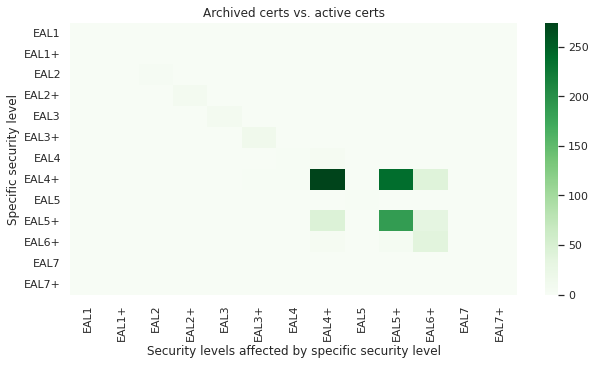

In [42]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 20})
heatmap_result = []


for security_level, counter in result.items():
    security_level_list = []
    for security_level_key in eals:
        security_level_list.append(counter.get(security_level_key, 0))
    
    heatmap_result.append(security_level_list)
    
sns.set(style="whitegrid")
ax = sns.heatmap(heatmap_result, xticklabels=eals, yticklabels=eals,cmap="Greens").set_title("Archived certs vs. active certs")
plt.ylabel("Specific security level")
plt.xlabel("Security levels affected by specific security level")

### Basic Analysis of most common category

In [43]:
cards_df = df[df["category"] == "ICs, Smart Cards and Smart Card-Related Devices and Systems"]
print(f"There are total {cards_df.shape[0]} rows ICs, Smart Cards and Smart Card-Related Devices and Systems category.")

There are total 1488 rows ICs, Smart Cards and Smart Card-Related Devices and Systems category.


#### How many certificates are active/archived

In [44]:
total_archived_certs = sum(cards_df["status"] == "archived")
total_active_certs = sum(cards_df["status"] == "active")

print(f"There are total {total_archived_certs} archived records among smart-cards")
print(f"There are total {total_active_certs} active records among smart-cards")

There are total 924 archived records among smart-cards
There are total 564 active records among smart-cards


#### Which manufacturer is the most common in this category?

In [45]:
most_common_smart_card_manufacturer = cards_df["manufacturer"].value_counts().index[0]
print(f"The most common manufacturer in smart cards category is: {most_common_smart_card_manufacturer}")

The most common manufacturer in smart cards category is: Infineon Technologies AG


#### Analysis of security levels of smart-cards

In [46]:
# The most common security level among smart-cards
most_common_sec_level = cards_df["highest_security_level"].value_counts().index[0]
sec_level_amount = cards_df["highest_security_level"].value_counts()[0]

print(f"Most common security level among smart-cards is {most_common_sec_level} with {sec_level_amount} occurences.")

Most common security level among smart-cards is EAL5+ with 671 occurences.


In [47]:
# The lowest common security level achieved in dataset
security_level_occurences = cards_df["highest_security_level"].value_counts()
filtered_sec_levels = [sec_level for sec_level, count in security_level_occurences.items() if count > 0]
level_numbers = {x: y for x, y in zip(eals, range(len(eals)))}

lowest_smart_card_security_level = None
lowest_security_level_int = None

for sec_level in filtered_sec_levels:
    if lowest_security_level_int is None:
        lowest_security_level_int = level_numbers[sec_level]
        lowest_smart_card_security_level = sec_level
    
    if level_numbers[sec_level] < lowest_security_level_int:
        lowest_security_level_int = level_numbers[sec_level]
        lowest_smart_card_security_level = sec_level
        
print(f"Lowest security level among smart cards in dataset: {lowest_smart_card_security_level}")

Lowest security level among smart cards in dataset: EAL1+


In [48]:
# The highest common security level in smart-card dataset
highest_smart_card_security_level = None
highest_security_level_int = None

for sec_level in filtered_sec_levels:
    if highest_security_level_int is None:
        highest_security_level_int = level_numbers[sec_level]
        highest_smart_card_security_level = sec_level
    
    if level_numbers[sec_level] > highest_security_level_int:
        highest_security_level_int = level_numbers[sec_level]
        highest_smart_card_security_level = sec_level
        
print(f"Highest security level among smart cards in dataset: {highest_smart_card_security_level}")

Highest security level among smart cards in dataset: EAL7


#### View data with lowest security level (EAL1+)

In [49]:
eal1_plus_df = cards_df[cards_df["highest_security_level"] == "EAL1+"]
eal1_plus_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,highest_security_level
dgst,,,,,,,,,,,,,,,,,,,,,
be0806db6fd6bbe8,NaN,ATMEL AT90SC6464C Integrated circuit (referenc...,archived,"ICs, Smart Cards and Smart Card-Related Device...",ATMEL Smart Card ICs,FR,"[AVA_VLA.2, EAL1+]",2001-01-01,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL1+
1a95d138ccc7814a,Rapport de certification 2001/16,CT2000 embedded Component (reference ST16RFHD5...,archived,"ICs, Smart Cards and Smart Card-Related Device...",ASK,FR,"[AVA_VLA.2, EAL1+]",2001-01-01,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL1+
35ac4cfd1f62df75,NaN,M/Chip Select v2.0.5.2 Application,archived,"ICs, Smart Cards and Smart Card-Related Device...",Mondex International Ltd,FR,"[AVA_VLA.2, EAL1+]",2001-01-01,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL1+
7c062b969e50e2af,Rapport de certification 2001/20,MODEUS electronic purse : MODEUS carrier card ...,archived,"ICs, Smart Cards and Smart Card-Related Device...","ASK, CP8, STMicroelectronics",FR,"[AVA_VLA.2, EAL1+]",2001-01-01,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL1+
f66157c81ab85729,Rapport de certification 2001/03,Oberthur B0' application v1.0.1 and GemClub v1...,archived,"ICs, Smart Cards and Smart Card-Related Device...","Oberthur Card Systems, Gemplus, Trusted Logic",FR,"[AVA_VLA.2, EAL1+]",2001-01-01,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL1+


In [50]:
eal1_plus_df["scheme"].value_counts()

FR    14
US     0
JP     0
CA     0
DE     0
ES     0
IN     0
IT     0
KR     0
UK     0
MY     0
NL     0
NO     0
SE     0
SG     0
TR     0
AU     0
Name: scheme, dtype: int64

#### View data with highest security level (EAL7)

In [51]:
eal7_df = cards_df[cards_df["highest_security_level"] == highest_smart_card_security_level]
eal7_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,highest_security_level
dgst,,,,,,,,,,,,,,,,,,,,,
8ee7145a1b48b578,ANSSI-CC-2020/33,MultiApp V4 JavaCard Virtual Machine,active,"ICs, Smart Cards and Smart Card-Related Device...",Gemalto,FR,[EAL7],2020-05-28,2025-05-28,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7
d08b5ddedd34448d,ANSSI-CC-2018/50,IDMotion V2 Multos Virtual Machine OS Multos V...,active,"ICs, Smart Cards and Smart Card-Related Device...",Gemalto / Trusted Labs,FR,[EAL7],2018-12-14,2023-12-14,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7
ff45605151ec4eb1,ANSSI-CC-2013/40,Virtual Machine of Multos M3 G230M mask with A...,archived,"ICs, Smart Cards and Smart Card-Related Device...",Multos international / Trusted Labs,FR,[EAL7],2013-07-04,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7
9231adbf747903df,ANSSI-CC-2013/12,Memory Management Unit des microcontrôleurs SA...,archived,"ICs, Smart Cards and Smart Card-Related Device...","Samsung Electronics Co., Ltd. / Trusted Labs",FR,[EAL7],2013-03-29,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7
890f788a91fc2fa1,ANSSI-CC-2013/11,Virtual Machine of ID Motion V1 G231 mask with...,archived,"ICs, Smart Cards and Smart Card-Related Device...",Gemalto / Trusted Labs,FR,[EAL7],2013-03-29,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7


In [52]:
eal7_df["scheme"].value_counts()

FR    6
US    0
JP    0
CA    0
DE    0
ES    0
IN    0
IT    0
KR    0
UK    0
MY    0
NL    0
NO    0
SE    0
SG    0
TR    0
AU    0
Name: scheme, dtype: int64

In [53]:
eal7_df[eal7_df["status"] == "active"]

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,highest_security_level
dgst,,,,,,,,,,,,,,,,,,,,,
8ee7145a1b48b578,ANSSI-CC-2020/33,MultiApp V4 JavaCard Virtual Machine,active,"ICs, Smart Cards and Smart Card-Related Device...",Gemalto,FR,[EAL7],2020-05-28,2025-05-28,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7
d08b5ddedd34448d,ANSSI-CC-2018/50,IDMotion V2 Multos Virtual Machine OS Multos V...,active,"ICs, Smart Cards and Smart Card-Related Device...",Gemalto / Trusted Labs,FR,[EAL7],2018-12-14,2023-12-14,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL7


#### BSI certs in smart cards dataset

In [54]:
bsi_smart_cards_df = cards_df[cards_df["is_bsi_cert"]]

print(f"There is total of {bsi_smart_cards_df.shape[0]} records among smart cards df")

There is total of 487 records among smart cards df


#### Most common security levels among BSI smart card record

In [55]:
bsi_smart_cards_df["highest_security_level"].value_counts()

EAL4+    198
EAL5+    185
EAL6+     70
EAL3+     14
EAL3      11
EAL4       8
EAL7+      0
EAL7       0
EAL5       0
EAL2+      0
EAL2       0
EAL1+      0
EAL1       0
Name: highest_security_level, dtype: int64

#### Smarts cards which expires next year


In [56]:
next_year = datetime.datetime.now().year + 1

def is_expiring_next_year(series_datetime):
    return series_datetime.year == next_year


cards_next_year_expires_df = cards_df[cards_df["not_valid_after"].apply(is_expiring_next_year)]
cards_next_year_expires_df.head()

,cert_id,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,...,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,is_bsi_cert,is_anssi_cert,highest_security_level
dgst,,,,,,,,,,,,,,,,,,,,,
1d1da6ea21704b72,NaN,NXP JCOP 3 P60,active,"ICs, Smart Cards and Smart Card-Related Device...","NXP Semiconductors Germany GmbH, Business Unit...",NL,"[ALC_DVS.2, ALC_FLR.1, ASE_TSS.2, AVA_VAN.5, E...",2020-01-14,2022-08-02,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL5+
92ae986997c1d45c,BTBD-03-01-FR-01,AKiS v2.5.2N,active,"ICs, Smart Cards and Smart Card-Related Device...",TÜBİTAK BİLGEM UEKAE,TR,"[ALC_DVS.2, AVA_VAN.5, EAL4+]",2019-06-10,2022-06-09,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,EAL4+
3459c14186e8223f,ANSSI-CC-2018/38,eTravel 2.4 en configuration EAC SAC sur plate...,active,"ICs, Smart Cards and Smart Card-Related Device...",Gemalto,FR,"[ALC_DVS.2, AVA_VAN.5, EAL5]",2018-09-27,2022-09-27,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL5
5e2c3b2cbc9dca47,ANSSI-CC-2017/76,Plateforme JavaCard MultiApp V4.0.1 - PACE en ...,active,"ICs, Smart Cards and Smart Card-Related Device...",gemalto,FR,"[ALC_DVS.2, AVA_VAN.5, EAL5+]",2017-12-18,2022-12-18,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,EAL5+
aea11fd4d2a7709d,BSI-DSZ-CC-0808-V3-2017,TCOS Passport Version 2.1 Release 3/P60D144,active,"ICs, Smart Cards and Smart Card-Related Device...",T-Systems International GMBH,DE,"[ALC_DVS.2, ATE_DPT.2, AVA_VAN.5, EAL4+]",2017-12-15,2022-12-15,https://www.commoncriteriaportal.org/files/epf...,...,NaN,NaN,NaN,[BSI-DSZ-CC-0809-V3-2017],"{BSI-DSZ-CC-0809-V3-2017, BSI-DSZ-CC-0808-V3-2...","{BSI-DSZ-CC-0809-V3-2017, BSI-DSZ-CC-0808-V2-2...","{BSI-DSZ-CC-0808-2013, BSI-DSZ-CC-0885-2013, B...",True,False,EAL4+
